# Project 02

## Project Overview

1.   Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2.   Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3.   What can you infer about each of the distinct groups?

You may work in a small group on the project.
Your code and analysis should be delivered in an IPython Notebook by end of day Monday in two weeks 3/28 (or right before the meet-up 3/31).


## Network Data

I will select network data from [OpenFlights](https://openflights.org/data.html)

Openflights is *a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways, calculate statistics automatically, and share the resulting maps with friends and the world. You can also check airport route maps for nearly every airport in the world and find out what airlines fly where.*

I will use the *Routes* and *Airports* datasets to build the network. I already described this data in Assignment 4.

OpenFlights datasets include:
*   [Airports](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat)
*   [Airports-extended](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports-extended.dat)
*   [Airlines](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat)
*   [Routes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat)
*   [Planes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat)
*   [Countries](https://raw.githubusercontent.com/jpatokal/openflights/master/data/countries.dat)




I will use the *Airports* and *Routes* dtasets to build the network.  The **Source Airport ID** and **Airline ID** from the Routes dataset will be the network nodes. A route will be an edge between the two nodes. I will add weights - represented by the number of routes that each airine has leaving from each particular airport. The Airports dataset will provide additional airport node attributes.

## Variables

<u>Routes Dataset</u>

*   Source Airport ID
*   Airline ID

<u>Airports Dataset</u>

*   Name
*   City
*   Country
*   IATA
*   Latitude
*   Longtitude




## Data Loading

In [65]:
# Import packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
%matplotlib inline

In [66]:
# Routes dataframe
routes_url = "https://raw.githubusercontent.com/nathtrish334/Data-620/main/Projects/Project_02/routes.dat"
df_routes = pd.read_csv(routes_url, 
                       header=None, sep=",", 
                       usecols=[0,2], 
                       names=['Airline', 'Airport'])
# Remove rows with blanks
df_routes = df_routes.dropna()

# Preview
df_routes.head()

,Airline,Airport
0,2B,AER
1,2B,ASF
2,2B,ASF
3,2B,CEK
4,2B,CEK


Add Weights to the dataframe

The weight will be the count of the number of routes for each airline at each airport.


In [67]:
df_routes_copy = df_routes.copy() # mae a copy of the dataframe

df_routes_copy['weight'] = df_routes_copy.groupby('Airline')['Airport'].transform('count')

df_routes_copy.head()


,Airline,Airport,weight
0,2B,AER,42
1,2B,ASF,42
2,2B,ASF,42
3,2B,CEK,42
4,2B,CEK,42


In [68]:
len(df_routes_copy)

67663

## Additional Airport Data

In [69]:
# Airports dataframe
airports_url = "https://raw.githubusercontent.com/nathtrish334/Data-620/main/Projects/Project_02/airports.dat"
df_airports = pd.read_csv(airports_url, 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6, 7], 
                       names=['Airport Name','City','Country','IATA', 'Latitude', 'Longitude'])
df_airports.head()

,Airport Name,City,Country,IATA,Latitude,Longitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001


In [70]:
len(df_airports) # Number of airports in the dataset

7698

In [71]:
# Merge the two datasets based on Airport and IATA 
df_airports_copy = df_airports.copy()
df_merged = pd.merge(df_routes_copy,df_airports_copy,left_on='Airport',right_on='IATA',how='inner')

df_merged.head()



,Airline,Airport,weight,Airport Name,City,Country,IATA,Latitude,Longitude
0,2B,AER,42,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
1,7J,AER,34,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
2,9U,AER,38,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
3,B2,AER,82,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
4,HY,AER,151,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566


In [72]:
# Airport Nodes
airport_nodes = df_merged[['Airport','Airport Name','City','Country','IATA','Latitude','Longitude']].drop_duplicates().sort_values(by='Airport')

# Airline Codes that Match Airport Codes
set(df_merged['Airline']) & set(df_merged['Airport']) 



{'ABJ', 'IOS'}

Since **ABJ** and **IOS** codes are used for both airlines and airports, there is need to add differentiate names before adding the airport atributes to the graph. For these two codes, I will add AL to represent AirLines.

In [73]:
df_merged['Airline'] = np.where(df_merged['Airline'].isin(['ABJ', 'IOS']),
    'AL_' + df_merged.Airline.map(str),
    df_merged.Airline
)
set(df_merged['Airline']) & set(df_merged['Airport']) 

set()

In [74]:
df_merged.head()

,Airline,Airport,weight,Airport Name,City,Country,IATA,Latitude,Longitude
0,2B,AER,42,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
1,7J,AER,34,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
2,9U,AER,38,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
3,B2,AER,82,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566
4,HY,AER,151,Sochi International Airport,Sochi,Russia,AER,43.449902,39.9566


In [75]:
## Creating the Network
G = nx.Graph()
G.add_nodes_from(df_merged['Airline'], bipartite=0)
G.add_nodes_from(df_merged['Airport'], bipartite=1)
G.add_weighted_edges_from([tuple(d) for d in df_merged[['Airline','Airport','weight']].values])

nx.set_node_attributes(G, airport_nodes.set_index('Airport').to_dict('index'))

# Network info
print(nx.info(G))

Graph with 3819 nodes and 19057 edges


In [76]:
# Nodes
airline_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
airport_nodes = set(G) - airline_nodes

In [77]:
# Check if network is connected
nx.is_connected(G)

False

In [78]:

# Check if the Graph is Bipartite
bi.is_bipartite(G)


True

In [79]:
# Density of he graph
print(bi.density(G, airline_nodes))

0.010335248855134054


In [80]:
print(bi.density(G, airport_nodes))

0.010335248855134054


## Island method

A node that is not connected by at least one edge with a chosen minimum weight will be trimmed from the graph.

In [81]:
def trim_edges(g, weight=1): 
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def get_islands(g, iterations=3, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

# Running get_islands function for 3 iterations and a minimum weight of 300
islands = get_islands(G, 4, 300)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    #connected_compntns = len(list(nx.connected_component_subgraphs(i[1])))
    connected_compntns = len(list(G.subgraph(c) for c in nx.connected_components(i[1])))
    print("\nMinimum weight: " + str(threshold) + 
          "\nNumber of nodes: " + str(graph_size)  + 
          "\nNumber of island subgraphs: " + str(connected_compntns)
          )


Minimum weight: 300
Number of nodes: 1814
Number of island subgraphs: 1

Minimum weight: 1028
Number of nodes: 1060
Number of island subgraphs: 1

Minimum weight: 1756
Number of nodes: 776
Number of island subgraphs: 1


### Graph of the Largest Island

In [82]:
# Function that lets you specify colors fo the nodes
def define_colors(grph, color1, color2):
    colors = []
    for node, data in G0.nodes(data=True):
        if data['bipartite'] == 1: 
            colors.append(color1) # Airports in Green    
        else:
            colors.append(color2)  # Airlines in Blue
        return colors

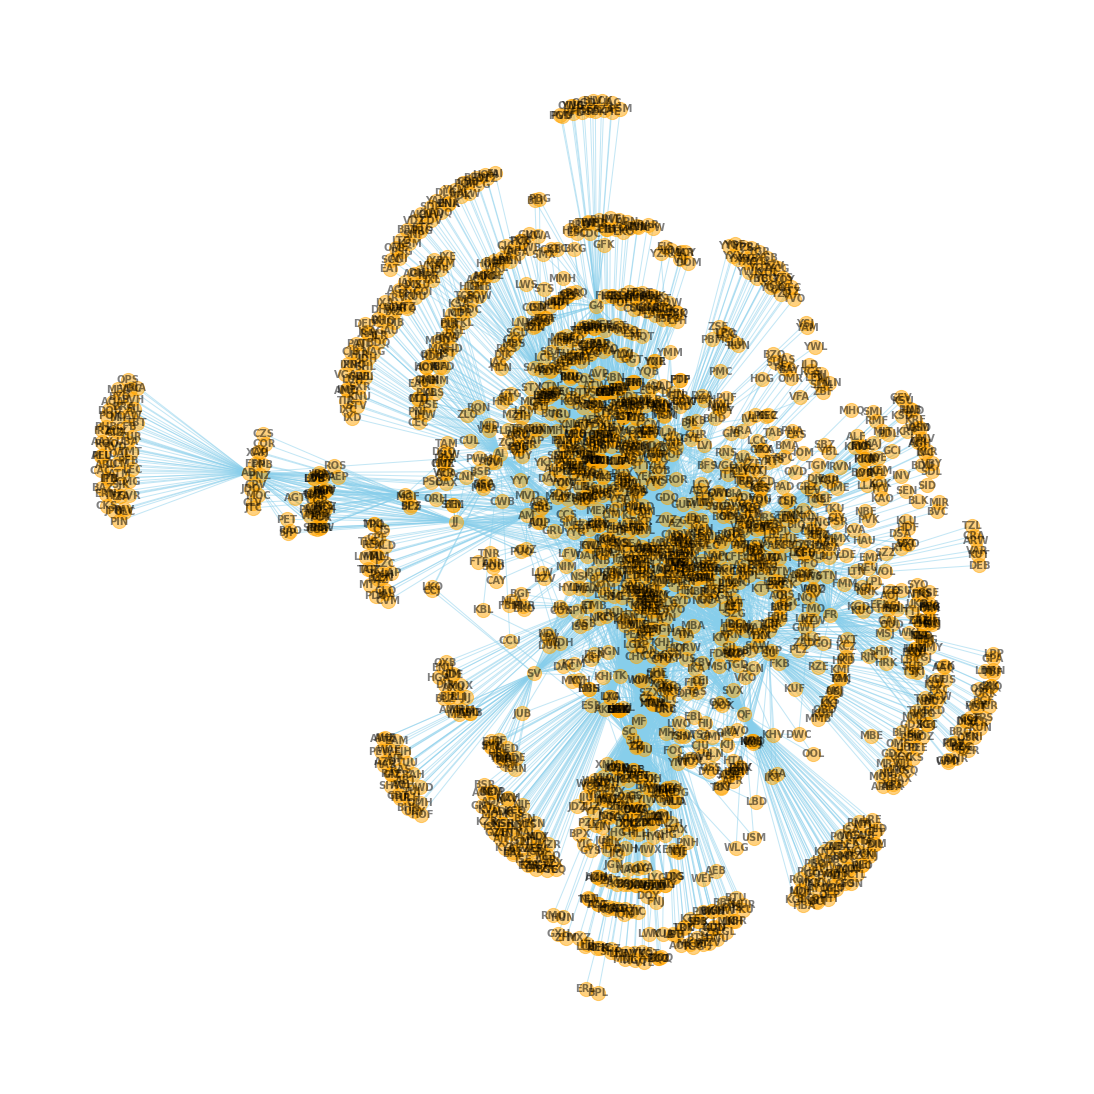

In [83]:
#G0=max(nx.connected_components(islands[0][1]), key=len)
G0=islands[0][1]

colors = define_colors(G0, "plum", "orange")
plt.rcParams["figure.figsize"] = (15,15) # set plot size
#colors = set_colors(G0)  # set colors
#weights = [math.log(edata['attr_dict'][200]) for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G0, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)



Here we can visualize how airports are connected by a smaller number of airlines as expected. To gain more insight a higher weight level is needed.

### Graph of the Second Largest Island

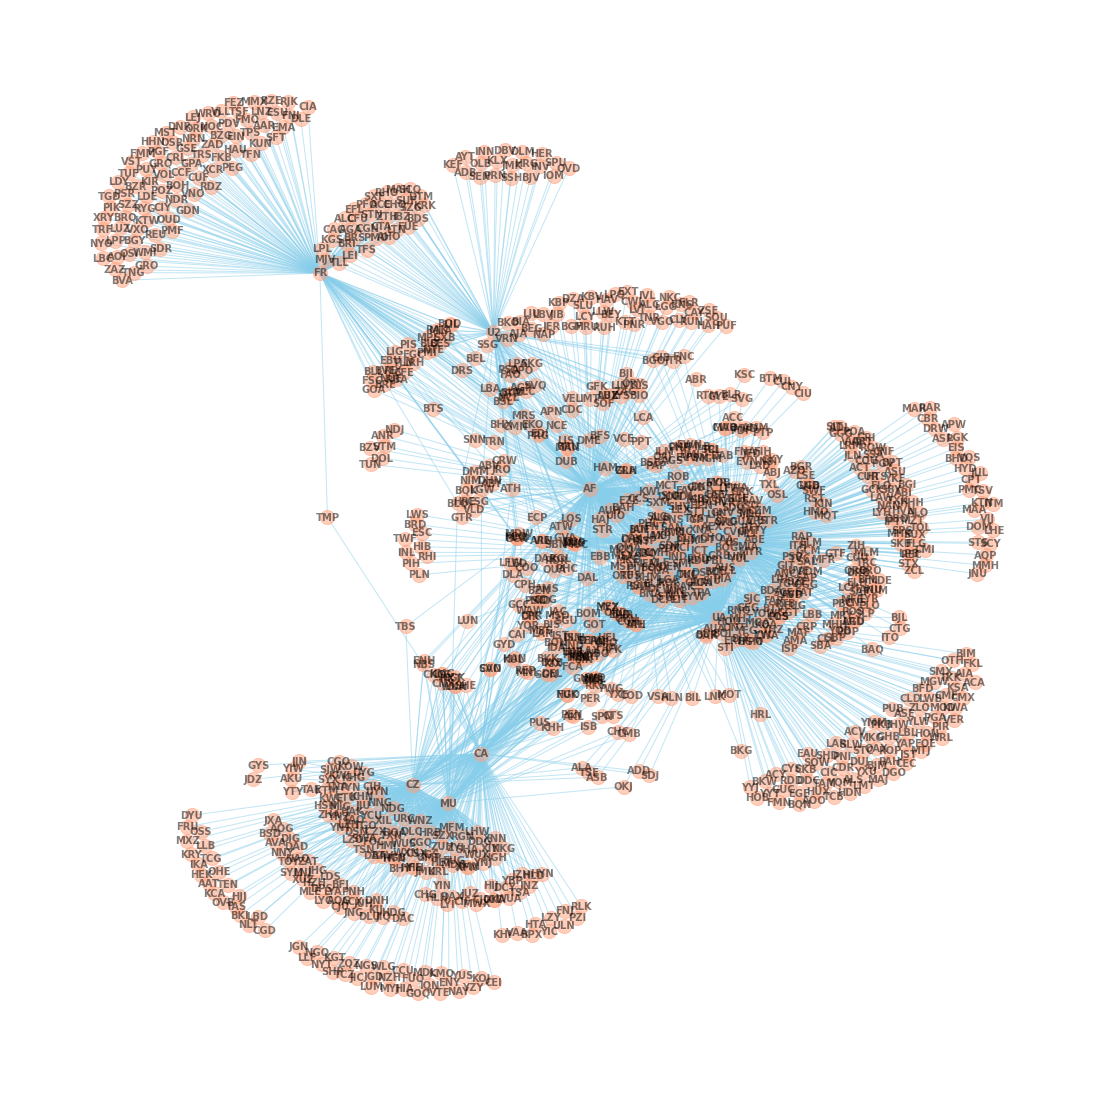

In [84]:
G1=islands[1][1]
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = define_colors(G1,"LemonChiffon", "lightsalmon")  # set colors

nx.draw(G1, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)


With a minimum weight of 1028 the connections between major airlines with is clearer

### Graph of the Third Largest Island

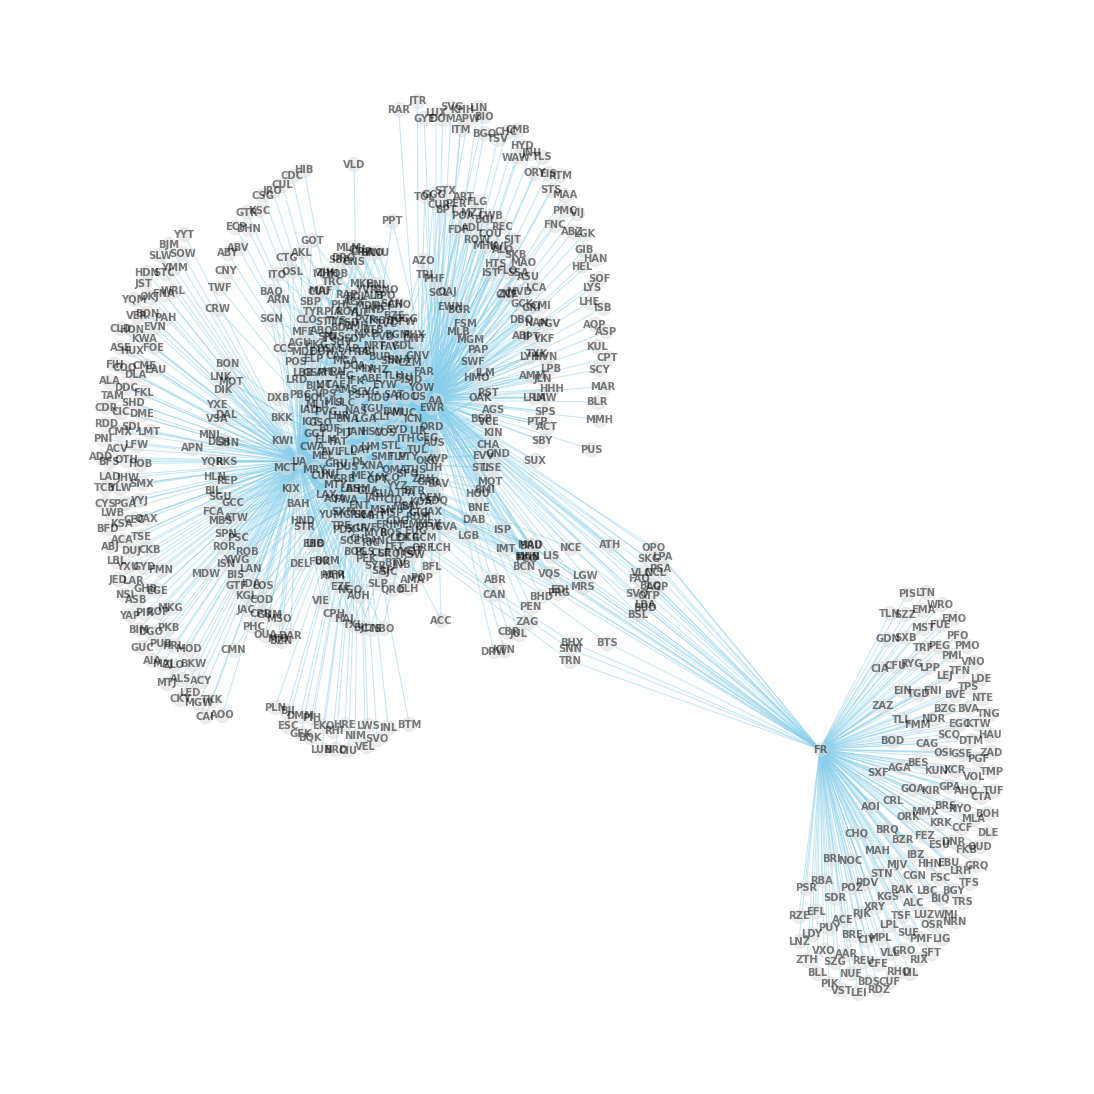

In [85]:
G2=islands[2][1]
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = define_colors(G1,"aquamarine", "gainsboro")  # set colors

nx.draw(G2, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="skyblue", alpha=0.5)


From this graph, the three most influential airlines in the network are:
*   FR - Air France
*   UA - United Airlines
*   AA - American Airlines
